In [284]:
# Import
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

import seaborn as sns
import pickle
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import backend as K
# import helper functions
import sys
# add our pipeline folder to the path to import functions
sys.path.insert(1, '../2_modeling')
from model_helper_no_cache import *
%matplotlib inline
import copy

from sklearn.metrics import roc_curve, auc


"""
nb_extensions
https://github.com/ipython-contrib/jupyter_contrib_nbextensions/blob/master/README.md
https://github.com/Jupyter-contrib/jupyter_nbextensions_configurator/blob/master/README.md
"""

'\nnb_extensions\nhttps://github.com/ipython-contrib/jupyter_contrib_nbextensions/blob/master/README.md\nhttps://github.com/Jupyter-contrib/jupyter_nbextensions_configurator/blob/master/README.md\n'

# List the files of saved models


In [2]:
# Path
models_path = '../../efs/models'
checkpoint_path='../../efs/models/Checkpoints/'
training_history_path='../../efs/models/Training_history/'
saved_models_path='../../efs/models/Saved_models/'

In [3]:
os.listdir(saved_models_path)

['model_ALL_FEATURES_sample_size_all_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10.h5',
 'model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10featuresextended.h5',
 'model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10.h5',
 'model_no_cache_test_sample_size_all_epoch_20_dense_2_neurons_512_losswbc__num_open_layers_2_penalty_weight_10.h5',
 'model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_1_penalty_weight_10.h5']

In [4]:
os.listdir(checkpoint_path)

['model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_1_penalty_weight_10.ckpt.data-00000-of-00002',
 'model__sample_size_500_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10featuresextended.ckpt.data-00000-of-00002',
 'model__sample_size_500_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10featuresextended.ckpt.index',
 'model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_1_penalty_weight_10.ckpt.index',
 'model_no_cache_test_sample_size_all_epoch_2_dense_2_neurons_256_losswbc__num_open_layers_1_penalty_weight_10.ckpt.data-00000-of-00002',
 'checkpoint',
 'model_no_cache_test_sample_size_all_epoch_2_dense_2_neurons_256_losswbc__num_open_layers_1_penalty_weight_10.ckpt.index',
 'model_no_cache_test_sample_size_all_epoch_1_dense_2_neurons_512_losswbc__num_open_layers_2_penalty_weight_10_sanity_check.ckpt.data-00001-of-00002',
 'model_no_cache_test_sample_size_all_epoch_20_dense_2_n

In [5]:
os.listdir(training_history_path)

['model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_1_penalty_weight_10.pickle',
 'model_no_cache_test_sample_size_all_epoch_20_dense_2_neurons_512_losswbc__num_open_layers_2_penalty_weight_10.pickle',
 'model2_sample_sizeall_epoch50_dense2_losswbc_history_log.csv',
 'model_no_cache_test_sample_size_14000_epoch_2_dense_2_neurons_256_losswbc__num_open_layers_1_penalty_weight_10_history_log.csv',
 'model_no_cache_test_sample_size_all_epoch_20_dense_2_neurons_512_losswbc__num_open_layers_2_penalty_weight_10_history_log.csv',
 'model__sample_size_15000_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_1_penalty_weight_10_history_log.csv',
 'model__sample_size_500_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10featuresextended_history_log.csv',
 'model_no_cache_test_sample_size_all_epoch_2_dense_2_neurons_256_losswbc__num_open_layers_1_penalty_weight_10_history_log.csv',
 'model_ALL_FEATURES_sample_size_all_epoch_20_dense_2_neuro

# Set the parameter

In [6]:
weights='model_ALL_FEATURES_sample_size_all_epoch_20_dense_2_neurons_1024_losswbc__num_open_layers_2_penalty_weight_10'

csv = '../1_cleaning/metadata_cleaned3.csv'

number_of_images = 'all'

history=weights+'.pickle'

In [7]:
# Create train-test dataset
#name_of_model='model1_sample_sizeall_epoch50_dense2_losswbc'
# Test train split, plus the features that are used to binarize the data
X_train, X_val, y_train_bin, y_val_bin, features = train_test_split_custom(number_of_images, csv)


# Load the model

## Option 1 : load the saved model:

In [8]:
# Load the model
new_model = tf.keras.models.load_model('../../efs/models/Saved_models/' + weights + '.h5', \
                                       custom_objects={'weighted_bce': weighted_bce, 
                                                       'accuracy_on_zero': accuracy_on_zero,
                                                       'accuracy_on_one': accuracy_on_one, 
                                                       'precision_on_1': precision_on_1})

## Option 2:  load the architecture + weights

In [ ]:
# Architecture
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

transfer_layer = vgg.get_layer('block5_pool')

# cutting of the end of the model before the dense layers
conv_model = Model(inputs=vgg.input,
                   outputs=transfer_layer.output)

# freeze VGG
conv_model.trainable = False

num_label = y_train_bin.shape[1]

def create_model():
    # Start a new Keras Sequential model.
    model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    model.add(conv_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    model.add(Flatten())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    model.add(Dense(1024, activation='relu'))

    model.add(Dropout(0.2))
    
    model.add(Dense(1024, activation='relu'))

    model.add(Dropout(0.2))

    model.add(Dense(num_label, activation='sigmoid'))
    
    # Settings
    LR = 1e-5
    optimizer = Adam(lr=LR)
    loss = weighted_bce
    metrics = [accuracy_on_one, accuracy_on_zero]
    
    model.compile(optimizer=optimizer, 
                  loss=loss, 
                  metrics=metrics)
    
    return model


new_model=create_model()



In [ ]:
# Checkpoint path
# For weights to be saved each epoch
#checkpoint_path = '../../efs/models/Checkpoints/' + weights + '.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Loads the weights from the checkpoint path above
new_model.load_weights(checkpoint_path+weights+'.ckpt')

# Model architecture

In [9]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 709)              

# Predictions for the test dataset

In [243]:
# Create the datasets
# new_model.load_weights(checkpoint_path)
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

In [402]:
# Make the predictions
#%%time
# Takes 2:30 with 1000 images, 
# grab the predictions from the valadation ds
predictions_test = new_model.predict(val_ds)
#predictions_train = new_model.predict(train_ds)

# SAVE the prediction
#pickle.dump([predictions_test], open( "predictions.p", "wb" ) )

In [12]:
# Optional step - load the predictions from file
#pickle.dump([predictions_test], open( "predictions.p", "wb" ) )
# Load the prediction
#predictions_test= pickle.load( open( "predictions.p", "rb" ) )

# Evaluations

## Loss plots

In [255]:
# Load the training history
history=pickle.load(open(training_history_path+history, "rb" ))

TypeError: must be str, not dict

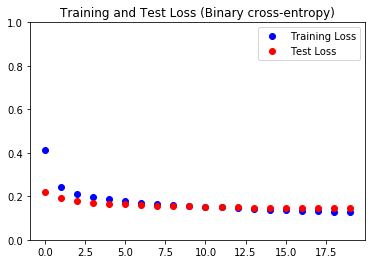

In [286]:
# Plot the training history
plot_training_history_loss(history)

## Model prediction on features that are present in photo

In [504]:
def plot_per_feature_error(predictions, actual, features, diff=False):
    
    """return plot of boxplot of predictions when the feature is active"""
    
    only_ones = np.array([np.where(y_true == 1, pred, np.nan) for y_true, pred in zip(actual,
                                                                                  predictions)])
    pred_df = pd.DataFrame(only_ones)
    
    # Name the classes 
    pred_df.columns = features

    # order the whole dataframe and return the column names
    order = pred_df.median().sort_values().keys()
    fig_dims = (22,10)
    fig, ax = plt.subplots(figsize=fig_dims)
    
    melted=pred_df.melt()
    #melted_with_medians = melted.merge(medians_per_feature, on='variable', how='left')
    #melted_with_medians['avg_prediction']=melted_with_medians['median']>0.5
    #my_pal = {"g", "r"}
    #boxprops = dict(linestyle='-', linewidth=4, color='grey', alpha=.1)
    
    sns.boxplot(x='variable', y='value', data=pred_df.melt(), whis=0, showfliers=False, order=order, boxprops=dict(alpha=.1))
    #sns.boxplot(x='variable', y='value', boxprops=boxprops, data=melted_with_medians, whis=0, hue='avg_prediction', palette=my_pal, showfliers=False, order=order)
    #boxprops=dict(alpha=.3)

    ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
    
    ax.set_xlabel('Fashion features', fontsize=30)
    ax.set_ylabel('Raw probabilities if the label is ON', fontsize=30)
    ax.set_title('Raw probabilities per feature if the label is ON', fontsize=40)
    ax.set(xticklabels=[])

    
    if diff:
        only_zeros = np.array([np.where(y_true == 0, pred, np.nan) for y_true, pred in zip(actual,
                                                                                  predictions)])
        pred_df2 = pd.DataFrame(only_zeros)
        pred_df2.columns = features
        
        pred_df=pred_df.reindex(pred_df.median().sort_values().index, axis=1)
        pred_df2=pred_df2.reindex(pred_df.median().sort_values().index, axis=1)
        
        
        median_ones=pred_df.median()
        median_zeros=pred_df2.median()
        diff=median_ones-median_zeros
        diff=pd.DataFrame(diff)

        sns.scatterplot(data=diff)

    return fig, ax

In [432]:
only_ones = np.array([np.where(y_true == 1, pred, np.nan) for y_true, pred in zip(y_val_bin,
                                                                              predictions_test)])
pred_df = pd.DataFrame(only_ones)

pred_df.columns = features

medians_per_feature=pred_df.median()
medians_per_feature=pd.DataFrame(medians_per_feature)
medians_per_feature['vairable']=medians_per_feature.index
medians_per_feature.columns=['median', 'variable']
medians_per_feature.head()



,median,variable
Glattleder,NaN,Glattleder
Lack,NaN,Lack
absatzart-blockabsatz,0.991638,absatzart-blockabsatz
absatzart-flach,0.976871,absatzart-flach
absatzart-keilabsatz,0.846827,absatzart-keilabsatz


709

(<Figure size 1584x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fed54d2db38>)

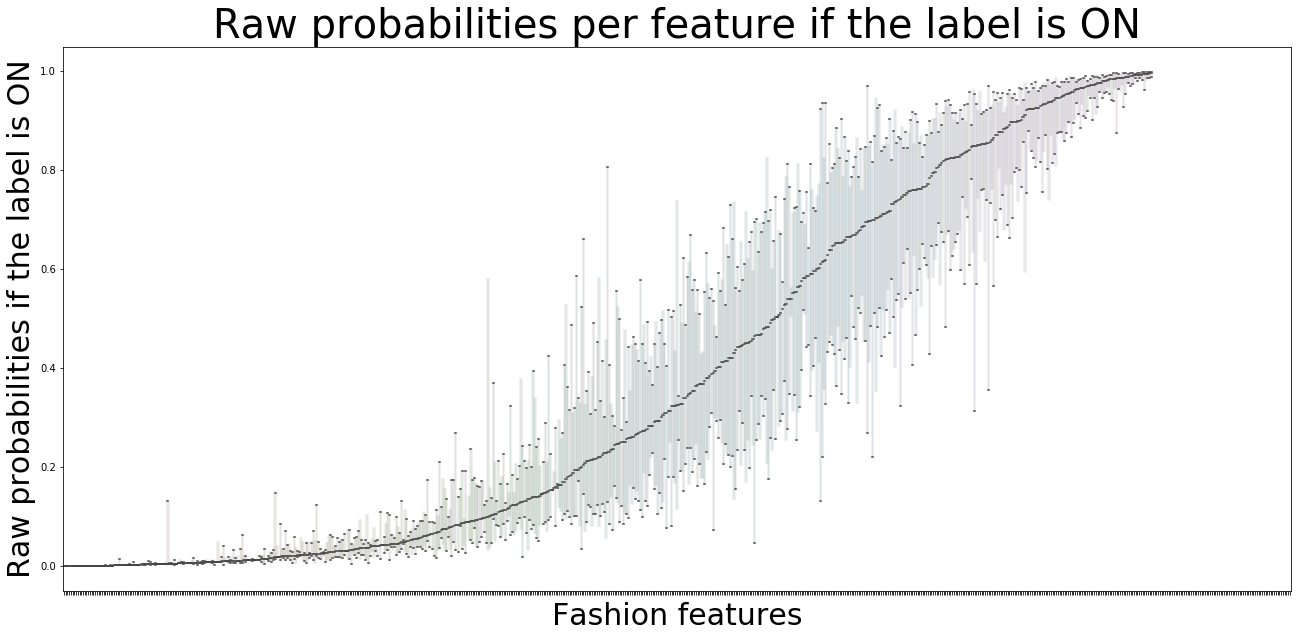

In [505]:
# Plot the predictions on 1s + the differences of medians 
plot_per_feature_error(predictions_test, y_val_bin, features, diff=False)

# Comment to the plot: 
- we predict x% of all the features correctly, if the label is on.


In [337]:
len(features)

709

# Recall and precision

## Predictions converted to 1 or 0 (threshold=0.5)

In [290]:
predictions_conv=copy.deepcopy(predictions_test)

predictions_conv[predictions_conv >= 0.5] =1 
predictions_conv[predictions_conv < 0.5] =0



In [291]:
predictions_conv

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

# True positives (TP)

In [293]:
true_pos=np.logical_and(predictions_conv, y_val_bin)
true_pos_df=pd.DataFrame(true_pos)
true_pos_df.columns = features
true_pos_per_feature=true_pos_df.sum(axis=0) 

In [338]:
true_pos_per_feature.head()

Glattleder                 0
Lack                       0
absatzart-blockabsatz    281
absatzart-flach          311
absatzart-keilabsatz      11
dtype: int64

## True 1s per feature

In [1]:
true_ones=pd.DataFrame(y_val_bin)
true_ones.columns = features
true_ones_per_feature=true_ones.sum(axis=0) 


NameError: name 'pd' is not defined

In [339]:
true_ones_per_feature.head()

Glattleder                 0
Lack                       0
absatzart-blockabsatz    283
absatzart-flach          315
absatzart-keilabsatz      13
dtype: int64

# Recall

In [297]:
recall=true_pos_per_feature/true_ones_per_feature

In [298]:
recall_sorted=recall.sort_values()

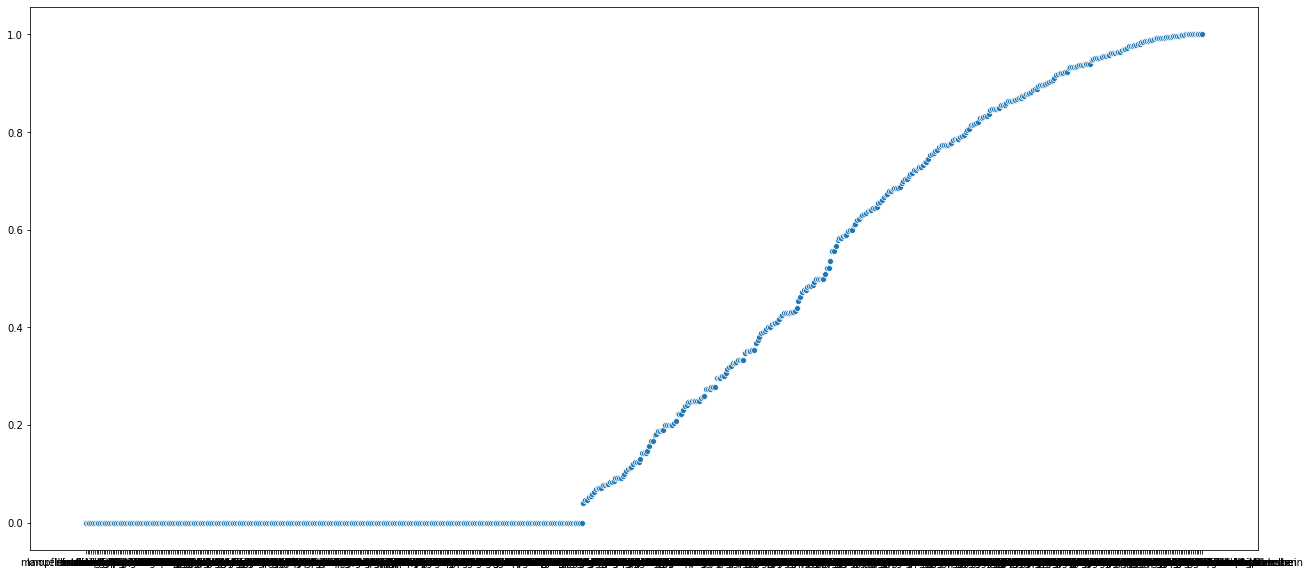

In [299]:
#order = recall.sort_values().keys()
fig_dims = (22,10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.scatterplot(data=recall_sorted)

#ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

## Precision

In [302]:
precision_df=pd.DataFrame(predictions_conv)
precision_df.columns = features
all_1_predictions_per_feature=precision_df.sum(axis=0) 

In [340]:
all_1_predictions_per_feature.head()

Glattleder                 0.0
Lack                       0.0
absatzart-blockabsatz    511.0
absatzart-flach          587.0
absatzart-keilabsatz      60.0
dtype: float32

In [304]:
precision=true_pos_per_feature/all_1_predictions_per_feature

In [305]:
len(precision[precision.isna()])

328

# Precision and recall per feature

In [480]:
combined=pd.concat([recall, precision], axis=1)
combined.columns= ['recall', 'precision']
combined=combined.sort_values(by='recall')
combined['features']=combined.index
combined_melt= combined.melt('features', var_name='cols', value_name='vals')


[]

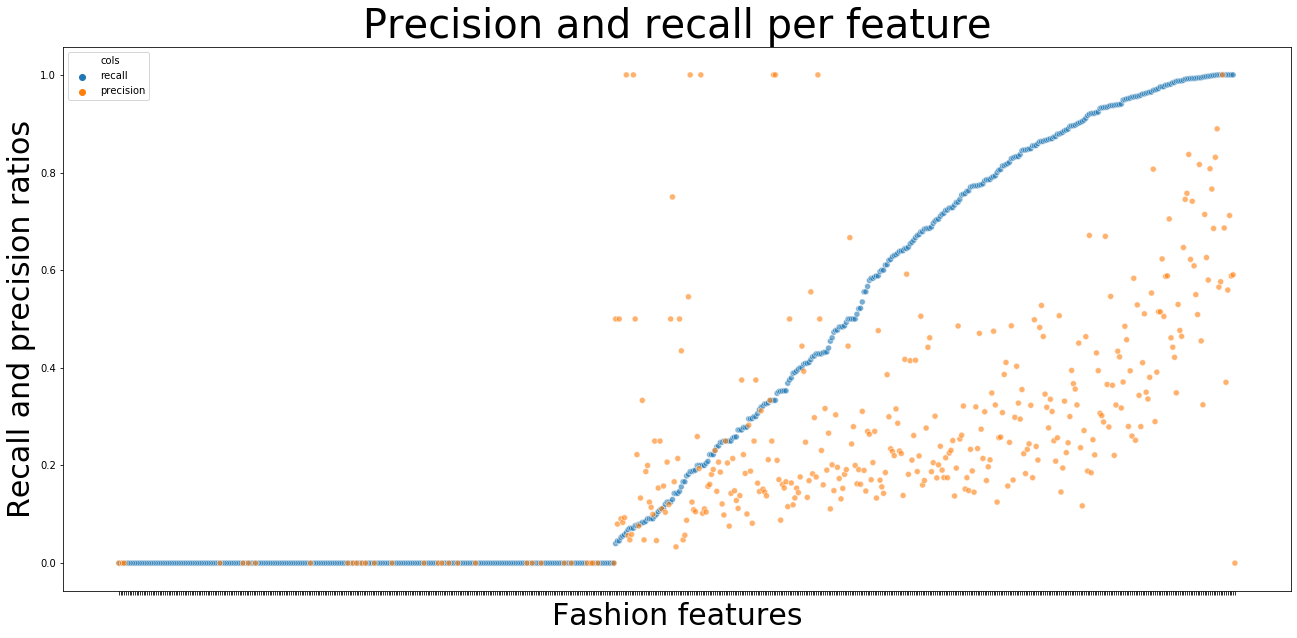

In [482]:
fig_dims = (22,10)
fig, ax = plt.subplots(figsize=fig_dims)
g = sns.scatterplot(x='features', y="vals", hue='cols', data=combined_melt, alpha=0.6)
g.set_xlabel('Fashion features', fontsize=30)
g.set_ylabel('Recall and precision ratios', fontsize=30)
g.set_title('Precision and recall per feature', fontsize=40)
g.set_xticklabels([],rotation=90)

## Reason why we have a significant number of features with 0s and NAs:

- 80 features do not appear in the test dataset -> recall is NA for them
- 280 features are not noticed -> recall is 0 -> rare presence
- 328 features, where we predict 0s only ->  precision is NA (in those cases recall can be either 0, or NA) 

In [491]:
combined[combined['recall']==0].shape

(280, 3)

In [483]:
combined[combined['recall'].isna()].shape

(80, 3)

In [484]:
combined[combined['precision'].isna()].shape

(328, 3)

In [485]:
combined2=pd.concat([recall, precision, true_ones_per_feature], axis=1)
combined2.columns= ['recall', 'precision', 'true_1s']
combined2=combined2.sort_values(by='recall')
combined2['features']=combined2.index
combined_melt2= combined2.melt('features', var_name='cols', value_name='vals')


In [487]:
combined2.head()

,recall,precision,true_1s,features
lila,0.0,0.0,14,lila
material-CAB,0.0,NaN,3,material-CAB
material-CA,0.0,0.0,24,material-CA
material-AF,0.0,0.0,27,material-AF
marine,0.0,NaN,7,marine


In [488]:
combined.head()

,recall,precision,features
lila,0.0,0.0,lila
material-CAB,0.0,NaN,material-CAB
material-CA,0.0,0.0,material-CA
material-AF,0.0,0.0,material-AF
marine,0.0,NaN,marine


[]

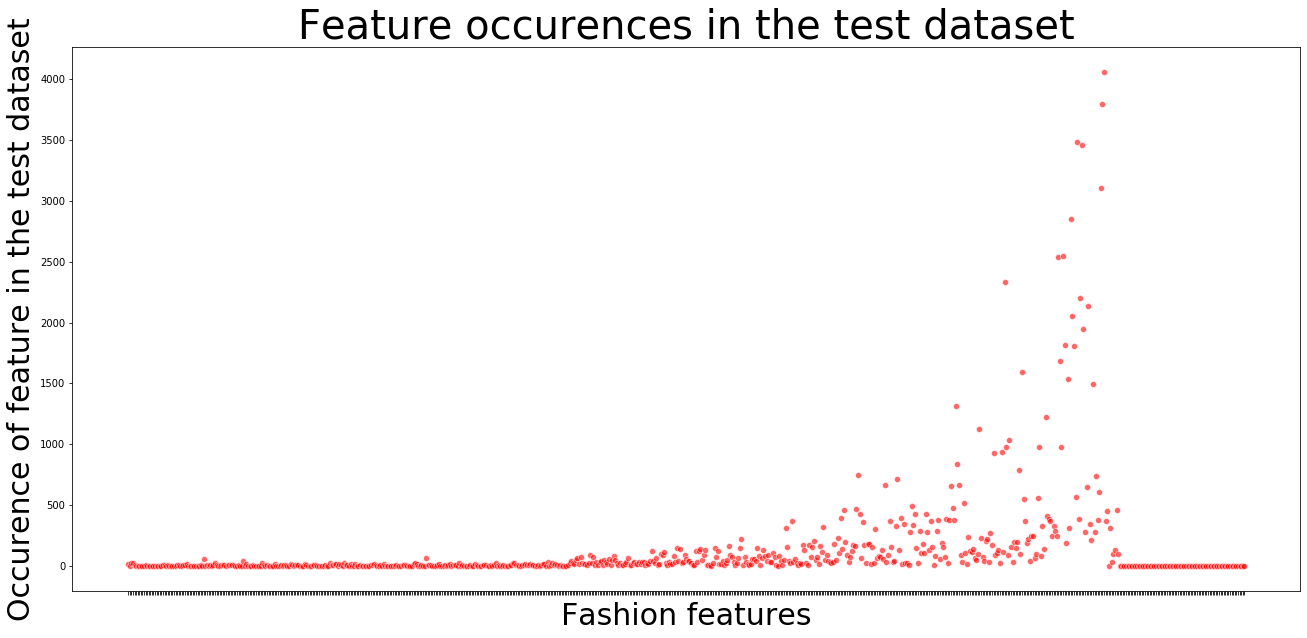

In [486]:
feature_occ=combined2['true_1s']

fig_dims = (22,10)
fig, ax = plt.subplots(figsize=fig_dims)
g = sns.scatterplot(data=feature_occ, alpha=0.6, color='r')
g.set_xlabel('Fashion features', fontsize=30)
g.set_ylabel('Occurence of feature in the test dataset', fontsize=30)
g.set_title('Feature occurences in the test dataset', fontsize=40)
g.set_xticklabels([],rotation=90)

In [490]:
len(combined2[combined2['true_1s']==0])

80

In [494]:
len(combined2[combined2['true_1s']<10])

316

# F1 Score added

## Ordered by Recall

In [308]:
combined=pd.concat([recall, precision], axis=1)
combined.columns= ['recall', 'precision']
combined=combined.sort_values(by='recall')
combined['features']=combined.index

#F1 Score = 2*(Recall * Precision) / (Recall + Precision)
combined['f1']= 2*combined['recall']*combined['precision']/(recall+precision)
#combined=combined.sort_values(by='f1')

In [309]:
combined_melt= combined.melt('features', var_name='cols', value_name='vals')


[]

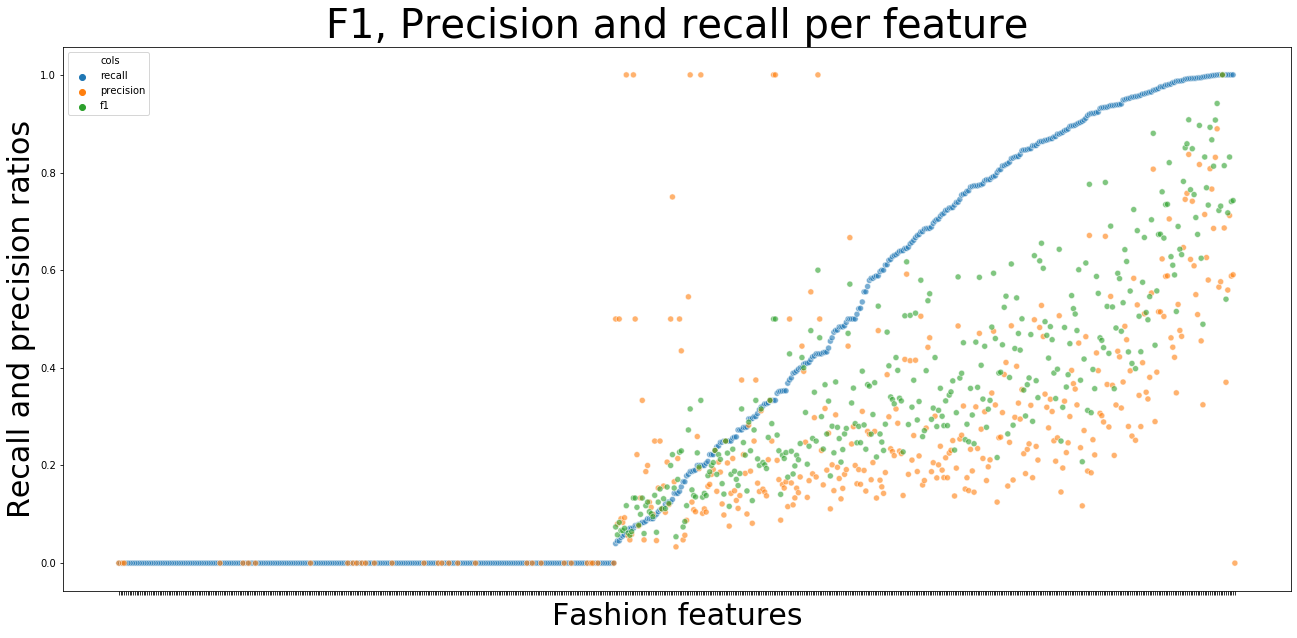

In [310]:
fig_dims = (22,10)
fig, ax = plt.subplots(figsize=fig_dims)
g = sns.scatterplot(x='features', y="vals", hue='cols', data=combined_melt, alpha=0.6)
g.set_xlabel('Fashion features', fontsize=30)
g.set_ylabel('Recall and precision ratios', fontsize=30)
g.set_title('F1, Precision and recall per feature', fontsize=40)
g.set_xticklabels([],rotation=90)

## Ordered by f1

In [311]:
combined=pd.concat([recall, precision], axis=1)
combined.columns= ['recall', 'precision']
#combined=combined.sort_values(by='recall')
combined['features']=combined.index

#F1 Score = 2*(Recall * Precision) / (Recall + Precision)
combined['f1']= 2*combined['recall']*combined['precision']/(recall+precision)
combined=combined.sort_values(by='f1')


In [442]:
combined['precision'].isna().sum()

328

In [441]:
combined['recall'].isna().sum()

80

In [312]:
combined['f1'].isna().sum()

360

In [313]:
combined_melt= combined.melt('features', var_name='cols', value_name='vals')


[]

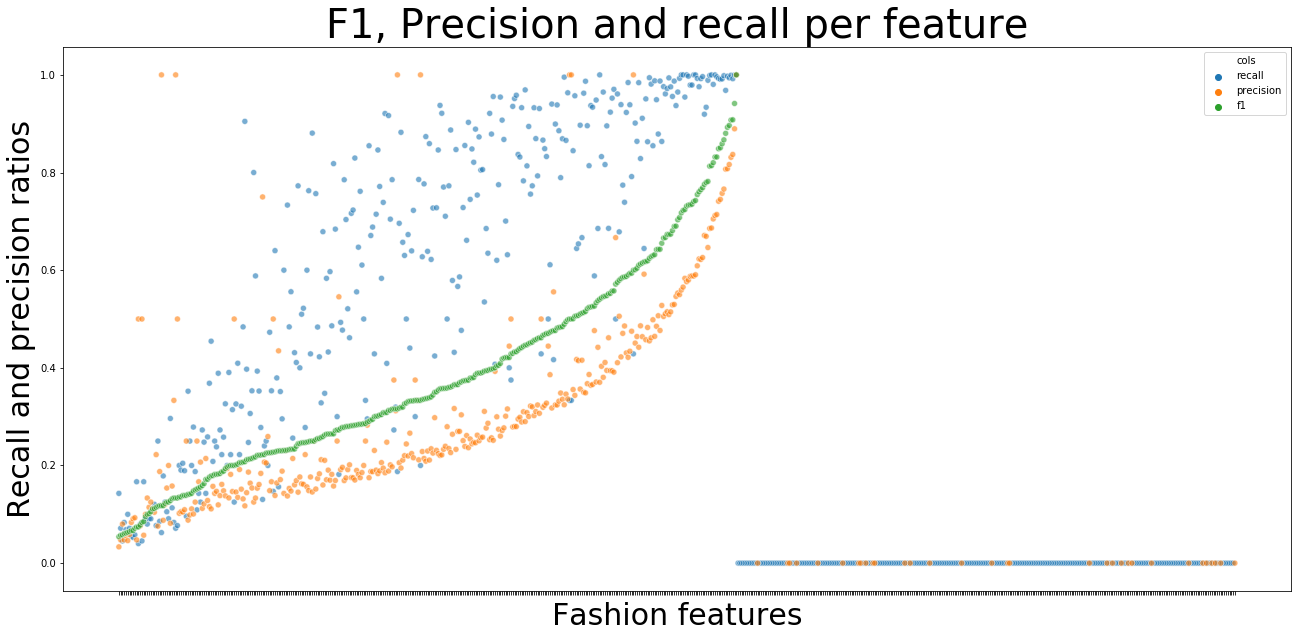

In [314]:
fig_dims = (22,10)
fig, ax = plt.subplots(figsize=fig_dims)
g = sns.scatterplot(x='features', y="vals", hue='cols', data=combined_melt, alpha=0.6)
g.set_xlabel('Fashion features', fontsize=30)
g.set_ylabel('Recall and precision ratios', fontsize=30)
g.set_title('F1, Precision and recall per feature', fontsize=40)
g.set_xticklabels([],rotation=90)

# F1, Precision, recall - ordered by F1

## Recall -  our positive predictions out of true positives
## Precision - true positives out of all our positive predictions


In [315]:
combined2= combined.dropna(subset=['f1'])

In [316]:
combined_melt2= combined2.melt('features', var_name='cols', value_name='vals')


[]

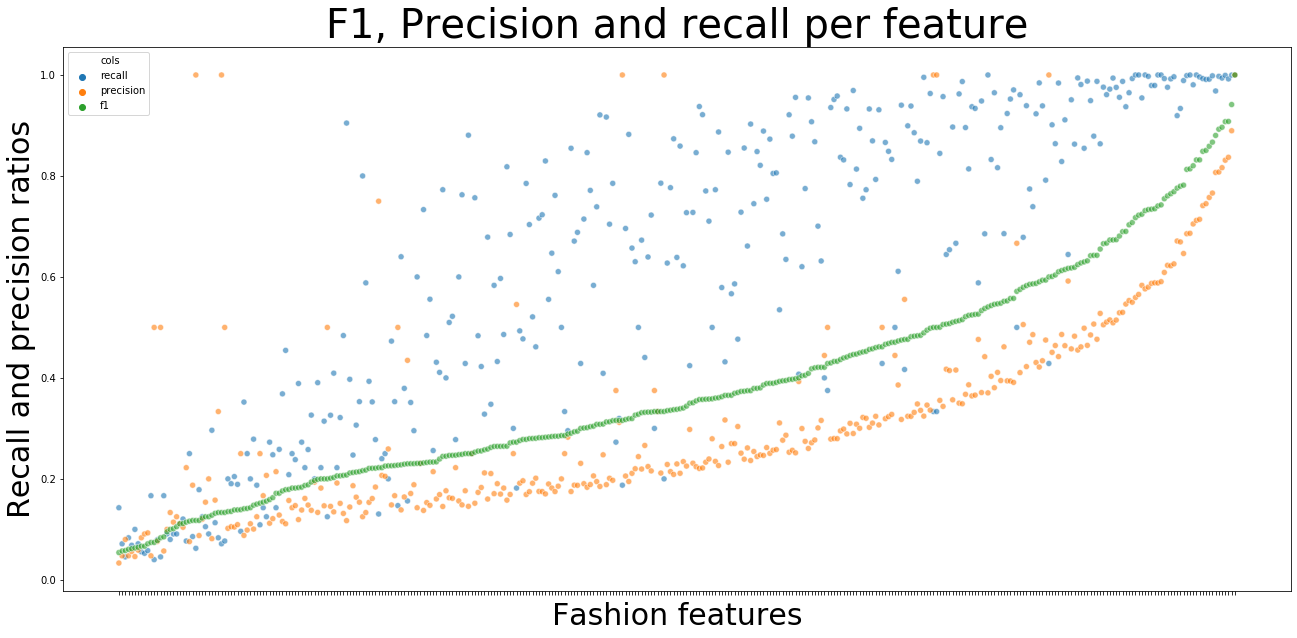

In [317]:
fig_dims = (22,10)
fig, ax = plt.subplots(figsize=fig_dims)
g = sns.scatterplot(x='features', y="vals", hue='cols', data=combined_melt2, alpha=0.6)
g.set_xlabel('Fashion features', fontsize=30)
g.set_ylabel('Recall and precision ratios', fontsize=30)
g.set_title('F1, Precision and recall per feature', fontsize=40)
g.set_xticklabels([],rotation=90)

# Features with the best F1 scores (>0.5) -> there are 93 features

In [346]:
combined2[combined2['f1']>0.5]['f1'].sort_values(ascending=False)

navdamentaschen-businesslaptoptaschen                           1.000000
bleichen-0                                                      0.941422
bundhohe-normalebundhohe                                        0.908005
trocknen-0                                                      0.907481
armellange-langarm                                              0.896450
anlass-freizeit                                                 0.892601
rocklange-inmidirocklange                                       0.880266
laufsohle-gummi                                                 0.866953
navmusterung-unifarben                                          0.858813
formschuhe-runderschuhspitze                                    0.850644
musterung-unifarben                                             0.848747
qualitaet-echtesleder                                           0.831794
schuhhoehe-Sneakertief                                          0.831746
armellange-kurzarm                                 

# Features with the worst F1 

In [347]:
combined2[combined2['f1']<0.2]['f1'].sort_values(ascending=False)

besonderheiten-guertelinklusive                     0.200000
navblusentuniken-schlupfblusen                      0.200000
armelform-raglanarmel                               0.199095
verschlussartfashion-verdeckterknopfleiste          0.196721
trocknen-2                                          0.193750
grau melange                                        0.188235
musterung-animalmuster                              0.186916
offwhite                                            0.183529
armabschluss-manschettenmitknoepfen                 0.182609
webart-auscord                                      0.181818
besonderheiten-dekorativeschleife                   0.181818
bordeaux                                            0.179211
laufsohle-textil                                    0.178571
weiss/                                              0.176101
beige                                               0.171558
karo                                                0.171429
ecru                    

## Recall on 1, recall on 0

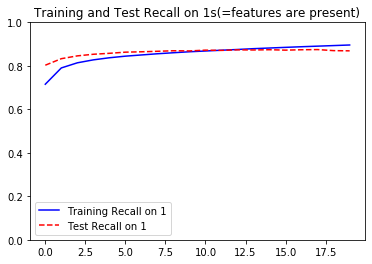

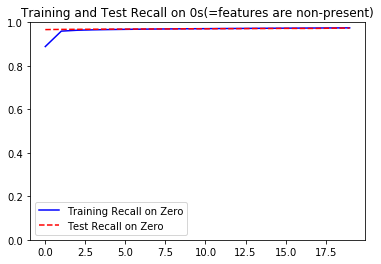

In [511]:
plot_training_history_recall_on_one(history)
plot_training_history_recall_on_zero(history)

# Precision

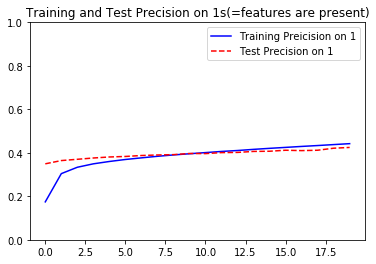

In [512]:
plot_training_history_precision_on_one(history)

## Make a prediction for an image

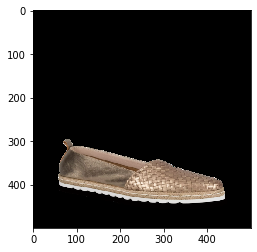

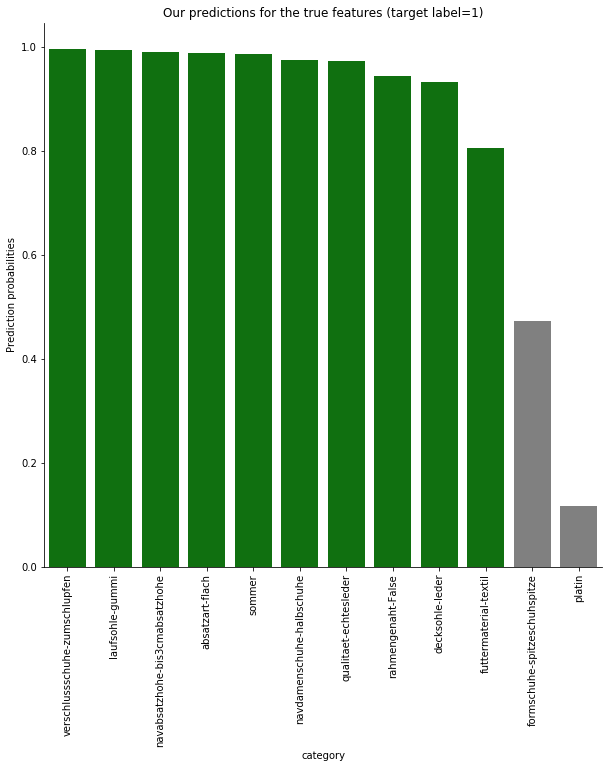

In [513]:
# Do a prediction for a photo
doPrediction(0, features, X_val, y_val_bin, predictions_test)

In [ ]:
doPrediction(1,features, X_val, y_val_bin, predictions_test)

In [ ]:
doPrediction(3,features, X_val, y_val_bin, predictions_test)

In [ ]:
doPrediction(4,features, X_val, y_val_bin, predictions_test)

## ROC AUC curve

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/rank

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/rank

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fed4d4393c8>)

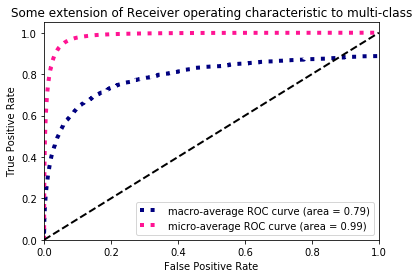

In [514]:
grouped_roc(y_val_bin, predictions_test)

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


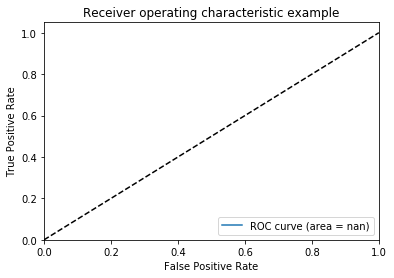

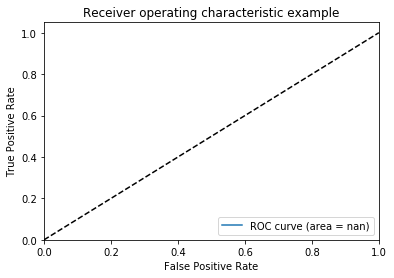

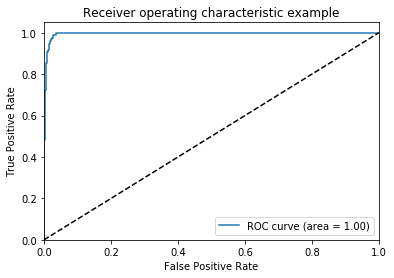

In [515]:
# Plot 3 ROC curves for 3 features
n_classes = y_val_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

    
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], predictions_test[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(3):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [242]:
# ROC AUC scores per feature
for i in range(112):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], predictions_test[:, i], pos_label=1)
    roc_auc[i] = auc(fpr[i], tpr[i])
    
roc_auc

/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)
/home/ubuntu/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/rank

{0: nan,
 1: nan,
 2: 0.9784639263991007,
 3: 0.97193902524299,
 4: 0.9193971393580886,
 5: 0.9750092596403145,
 6: 0.9354773871462005,
 7: 0.897899789978998,
 8: 0.5,
 9: 0.5,
 10: nan,
 11: 0.5,
 12: 0.815376696163804,
 13: 0.9500945808385632,
 14: 0.8972363580420097,
 15: 0.8813169205248077,
 16: 0.991598686997035,
 17: 0.6129995434484858,
 18: 0.5,
 19: 0.5,
 20: 0.5,
 21: 0.5,
 22: 0.5,
 23: 0.6204142234250488,
 24: 0.5390219681011135,
 25: 0.5,
 26: 0.5,
 27: 0.9100848774577589,
 28: 0.6827321881349385,
 29: 0.5,
 30: 0.9681678866220215,
 31: 0.49962366400722563,
 32: 0.5,
 33: 0.5531851159722986,
 34: 0.6623533223277681,
 35: 0.8788114213155565,
 36: 0.9550638518018391,
 37: 0.9443863007875061,
 38: 0.9371720619160891,
 39: 0.5,
 40: 0.8281081711236273,
 41: 0.9072799268961317,
 42: 0.5,
 43: 0.7463063470526158,
 44: 0.9150831944686248,
 45: 0.5,
 46: 0.8002517216413261,
 47: 0.894189657756637,
 48: 0.8682114267775859,
 49: 0.6564019688269074,
 50: 0.6854395747022605,
 51: 0.778